In [1]:
import xarray as xr
# import matplotlib.pyplot as plt
import datetime
from glob import glob
import dask, dask.distributed
import dask_jobqueue
import matplotlib.pyplot as plt
import datetime
import numpy as np
# import parcels
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import cartopy.crs as ccrs
import cmocean
from xhistogram.xarray import histogram as xhist
import seawater as gsw
import matplotlib.colors as mcolors
import datetime as dt 

In [2]:
cluster = dask_jobqueue.SLURMCluster(

    # Dask worker size
    cores=4, memory='16GB',
    processes=1, # Dask workers per job
    
    # SLURM job script things
    queue='base', walltime='04:00:00',
    
    # Dask worker network and temporary storage
    interface='ib0', local_directory='$TMPDIR',  # for spilling tmp data to disk
    log_directory='slurm/' 
)

client = dask.distributed.Client(cluster)

cluster.scale(jobs=15) #15
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.18.4.22:43771/status,
Dashboard: http://172.18.4.22:43771/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.18.4.22:37263,Workers: 0
Dashboard: http://172.18.4.22:43771/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
def filter_beached_particles(ds,dim=None):
    """
    Filter particles in the dataset based on salinity.

    Parameters:
    ds (xarray.Dataset): The dataset containing salinity data.

    Returns:
    xarray.Dataset: A filtered dataset including only particles that have not reached zero salinity.
    """
    # Identify particles that reach zero salinity
    particles_reach_zero_salinity = (ds.salt == 0).any(dim)

    # Identify particles that have not reached zero salinity (beached)
    particles_beached = ~particles_reach_zero_salinity

    # Filter the dataset to include only particles that have not reached zero salinity
    ds_particles_reach_zero_salinity_beached = ds.where(particles_beached.compute(), drop=True)

    return ds_particles_reach_zero_salinity_beached


In [8]:
#ds_orig = xr.open_dataset('data/level2/parcels_releases_seed-2345.zarr', engine='zarr', chunks='auto')

In [9]:
ds = xr.open_dataset('data/level2/retry_with_time_parcels_releases_seed-2345.zarr', engine='zarr', chunks='auto')
ds = filter_beached_particles(ds,'time')


In [10]:
def compute_density(ds):
    ds_density = xr.apply_ufunc(gsw.eos80.pden,ds.salt,ds.temp,0,dask='parallelized',output_dtypes=[np.float64]) - 1000
    ds_add_dens = ds.assign(sigma0=ds_density)
    return ds_add_dens

ds = compute_density(ds)

In [11]:
particles_less_than_28_kgm3 = (ds.sigma0 < 28).any('time')
particles_that_reach_28_kgm3 = ~particles_less_than_28_kgm3
ds_particles_greater_than_28_kgm3 = ds.where(particles_that_reach_28_kgm3.compute(), drop=True)
ds_overflows = ds_particles_greater_than_28_kgm3

In [10]:
#ds_particles_greater_than_28_kgm3.sigma0.isel(trajectory=100).plot();

In [15]:
# # this works! trajectories that are filtered out have a total summed salinity of 0! 

# test = ds_overflows.salt.sum(dim='time')#.where(ds_filter_slice.sum(dim='obs') == 0, drop=True).compute()

# # # Compute the boolean indexer first
# indexer = (ds_overflows.salt.sum(dim='time') == 0).compute()

# # Use the computed indexer for indexing
# print('percentage of particles removed from overflows filter i.e. density criterion =', 
#       ((ds.trajectory.size - test.where(~indexer, drop=True).trajectory.size)/ds_overflows.trajectory.size)*100, '%')


# #ds_particles_greater_than_28_kgm3.sigma0.isel(trajectory=1).plot();

In [74]:
# ds_overflows.isel(trajectory=1).salt.sum(dim='time').values
# ds_overflows.isel(trajectory=100).salt.sum(dim='time').values

In [20]:
# # this works! trajectories that are filtered out have a total summed salinity of 0! 

# test = ds_southward.salt.sum(dim='time')#.where(ds_filter_slice.sum(dim='obs') == 0, drop=True).compute()

# # # Compute the boolean indexer first
# indexer = (ds_southward.salt.sum(dim='time') == 0).compute()

# # Use the computed indexer for indexing
# print('percentage of particles removed from overflows filter i.e. density criterion =', 
#       ((ds.trajectory.size - test.where(~indexer, drop=True).trajectory.size)/ds_southward.trajectory.size)*100, '%')


# #ds_particles_greater_than_28_kgm3.sigma0.isel(trajectory=1).plot();

In [233]:
# n = 6878
# ds.isel(time=slice(n,n+365*2-1)).time # 8766 hours in a year

In [232]:
# n = 5415
# ds.isel(time=slice(n,n+365*2+1)).time # 8766 hours in a year

In [12]:
yr_2002_2003 = slice(11991,12720+int(8766/12))
yr_1999_2000 = slice(14181,14181+365*2+2+int(8766/12))

In [13]:
yr_2012 = slice(5415,5415+365*2+1)
yr_2010 = slice(6878,6878+365*2-1)

In [14]:

import yaml
import os
outdir = 'data/level3/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
if os.path.exists(f'{outdir}/minmax.yaml'):
    with open(f'{outdir}/minmax.yaml', 'r') as file:
        results = yaml.load(file, Loader=yaml.FullLoader)
else:
    results = calc_min_max(ds)
    with open(f'{outdir}/minmax.yaml', 'w') as file:
        yaml.dump(results, file)

n=0.25
lon_bins = np.arange(results['lon_min'], results['lon_max'], n)
lat_bins = np.arange(results['lat_min'], results['lat_max'], n)

def rechunk_for_hist(var):
    return var.chunk({'trajectory': 50, 'time': -1})



In [15]:
# load in snapshot velocity and mesh masks

U_snapshot = xr.open_dataset('../../Data/U/U_velocity_2010-06-30.nc')
V_snapshot = xr.open_dataset('../../Data/V/V_velocity_2010-06-30.nc')

m = 1#650
U_m = U_snapshot.vozocrtx.isel(time_counter=0).sel(deptht=m,method='nearest')
V_m = V_snapshot.vomecrty.isel(time_counter=0).sel(deptht=m,method='nearest')

speed_m = (U_m**2 + V_m**2)**.5

mesh_mask = xr.open_dataset('../../Data/mesh_masks/mesh_mask.nc')
mesh_hzgr = xr.open_dataset('../../Data/mesh_masks/mesh_hzgr.nc')
mesh_hgr = xr.open_dataset('../../Data/mesh_masks/mesh_hgr.nc')

z = mesh_hzgr.e3t_0
t_mask = mesh_mask.tmask

# bathymetry (Depth level) at every grid point 
bathymetry = (z*t_mask).isel(t=0).sum(dim='z')

# turn zeros into nans, easier to see where continents are 
bath_total_nans = bathymetry.where(bathymetry != 0)
land_mask = mesh_mask.tmask.where(mesh_mask.tmask!=0).isel(t=0,z=0)

In [19]:
ds_2002_2003 = ds.isel(time=yr_2002_2003)
ds_overflow_2002_2003 = ds_overflows.isel(time=yr_2002_2003)

In [20]:
ds_1999_2000 = ds.isel(time=yr_1999_2000)
ds_overflow_1999_2000 = ds_overflows.isel(time=yr_1999_2000)

In [21]:
ds_overflow_2010 = ds_overflows.isel(time=yr_2010)
ds_overflow_2012 = ds_overflows.isel(time=yr_2012)

In [22]:
# look at seasonality

monthly_overflow = ds_overflows.groupby('time.month').mean(dim='time')

In [23]:
# #ds_overflows = ds.where(ds.sigma0 > 28,drop=False)

# ds = ds_overflows

In [10]:
# heat_map_obs = xhist(ds.lat, ds.lon, bins=[lat_bins, lon_bins], dim=['time'],
#     bin_dim_suffix="") #dim=['obs'],

# heat_map_traj = xhist(ds.lat, ds.lon, bins=[lat_bins, lon_bins], #, dim=['trajectory'], # with dim=trajectory, the  chunks were way too big over 5 Gib
#     bin_dim_suffix="")

In [107]:
# # Summing particle counts over the whole integration period
# heat_map_obs_sum = heat_map_traj#.sum(dim='obs')

# # Dividing by the total number of particle counts for all bins
# total_counts = heat_map_obs_sum.sum()
# heat_map_normalized = heat_map_obs_sum / total_counts

# # Calculate the total number of observations
# total_observations = ds.time.size

# # Calculate the probability for each bin
# heat_map_probability_obs = (heat_map_obs / total_observations) * 100

# # Summing particle counts over the whole integration period, considering each particle only once per bin
# heat_map_obs_unique = (heat_map_obs > 0).sum(dim='trajectory')

# # Dividing by the total number of particles to get the probability for each bin
# total_particles = ds.trajectory.size
# heat_map_probability = (heat_map_obs_unique / total_particles) * 100

In [ ]:
# #rechunked = heat_map_normalized.chunk({'lat': 100, 'lon': 100})

# # Compute the result
# heat_map_normalized_comp = heat_map_normalized.compute()

# heat_map_compute = heat_map_obs.sum(dim='trajectory').compute()

# heat_map_probability_compute = heat_map_probability.compute()

In [16]:
# lon_rechunk = rechunk_for_hist(ds['lon'])
# lat_rechunk = rechunk_for_hist(ds['lat'])

def rechunk_lat_lon(ds):
    """
    Rechunk latitude and longitude data from the given xarray dataset.

    Parameters:
    ds (xarray.Dataset): The input dataset containing 'lon' and 'lat' variables.

    Returns:
    tuple: A tuple containing the rechunked longitude and latitude arrays.
    """
    lon_rechunk = rechunk_for_hist(ds['lon'])
    lat_rechunk = rechunk_for_hist(ds['lat'])
    
    return lon_rechunk, lat_rechunk

In [17]:
def compute_heat_maps(ds):
    """
    Compute heat maps and probabilities from the given dataset.

    Parameters:
    ds (xarray.Dataset): The input dataset containing latitude, longitude, and trajectory data.
    lat_bins (array-like): The bins for latitude.
    lon_bins (array-like): The bins for longitude.

    Returns:
    dict: A dictionary containing the computed heat maps and probabilities.
    """
    
    # Compute heat map of observations
    heat_map_obs = xhist(ds.lat, ds.lon, bins=[lat_bins, lon_bins], dim=['time'], bin_dim_suffix="")
    
    # Compute heat map of trajectories
    heat_map_traj = xhist(ds.lat, ds.lon, bins=[lat_bins, lon_bins], bin_dim_suffix="")
    
    # Summing particle counts over the whole integration period
    heat_map_obs_sum = heat_map_traj
    
    # Dividing by the total number of particle counts for all bins
    total_counts = heat_map_obs_sum.sum()
    heat_map_normalized = heat_map_obs_sum / total_counts

    # Calculate the total number of observations
    total_observations = ds.time.size

    # Calculate the probability for each bin
    heat_map_probability_obs = (heat_map_obs / total_observations) * 100

    # Summing particle counts over the whole integration period, considering each particle only once per bin
    heat_map_obs_unique = (heat_map_obs > 0).sum(dim='trajectory')

    # Dividing by the total number of particles to get the probability for each bin
    total_particles = ds.trajectory.size
    heat_map_probability = (heat_map_obs_unique / total_particles) * 100

    # Compute the results
    heat_map_normalized_comp = heat_map_normalized#.compute()
    heat_map_compute = heat_map_obs.sum(dim='trajectory')#.compute()
    heat_map_probability_compute = heat_map_probability.compute()

    return {
        'heat_map_normalized': heat_map_normalized_comp,
        'heat_map_compute': heat_map_compute,
        'heat_map_probability': heat_map_probability_compute,
        'heat_map_probability_obs': heat_map_probability_obs
    }



In [26]:
def plot_particle_maps(ds_binned, cmap, cbar_label, title, vmin=None, vmax=None):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
    ax.set_extent([-40, 20, 55, 85], crs=ccrs.PlateCarree())
    
    # Plot the bathymetry data on the orthographic map
    pcolormesh = ax.pcolormesh(
        mesh_mask.nav_lon, mesh_mask.nav_lat, land_mask, 
        transform=ccrs.PlateCarree(), cmap='binary')
    
    # Determine vmin and vmax if not provided
    if vmin is None:
        vmin = np.min(ds_binned)
    if vmax is None:
        vmax = np.max(ds_binned)

    # Plot the particle density
    x = ax.pcolormesh(lon, lat, ds_binned, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    cbar = plt.colorbar(x)
    cbar.set_label(cbar_label)
    
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
    gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    ax.plot([5.5, -1], [62.24, 65.], color='tab:pink', label='Svinoy section', transform=ccrs.PlateCarree())
    ax.plot([-6.43, -6.43], [62.15, 64.5], color='tab:green', label='N section', transform=ccrs.PlateCarree())
    ax.plot([-15, -11.95], [66.25, 68.7], color='blue', label='LN section', transform=ccrs.PlateCarree())
    ax.plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
    ax.set_title(title)
    plt.show()

In [67]:


test = xhist(monthly_overflow.lat, monthly_overflow.lon, bins=[lat_bins, lon_bins], dim=['trajectory'], bin_dim_suffix="")

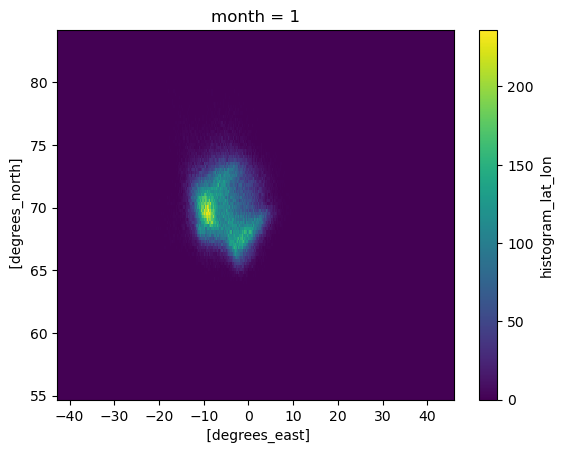

In [69]:
test.isel(month=0).plot()

In [24]:
#lon,lat = heat_map_probability_obs.lon,heat_map_probability_obs.lat

heat_map_ds_2002_2003 = compute_heat_maps(ds_2002_2003)['heat_map_probability']

In [25]:
lon, lat= heat_map_ds_2002_2003.lon,heat_map_ds_2002_2003.lat

In [29]:
heat_map_overflow_2002_2003 = compute_heat_maps(ds_overflow_2002_2003)['heat_map_probability']

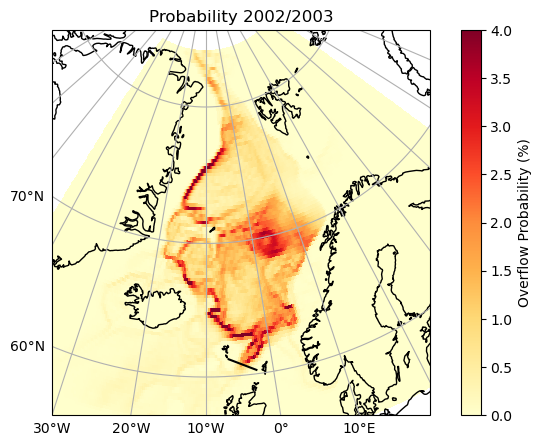

In [ ]:
plot_particle_maps(heat_map_ds_2002_2003, 'YlOrRd', 'Overflow Probability (%)', 'Probability 2002/2003',vmin=0,vmax=4)
plot_particle_maps(heat_map_overflow_2002_2003, 'YlOrRd', 'Overflow Probability (%)', 'Overflow Probability 2002/2003',vmin=0,vmax=4)

In [36]:
heat_map_ds = compute_heat_maps(ds)['heat_map_probability']
heat_map_overflow = compute_heat_maps(ds_overflows)['heat_map_probability']

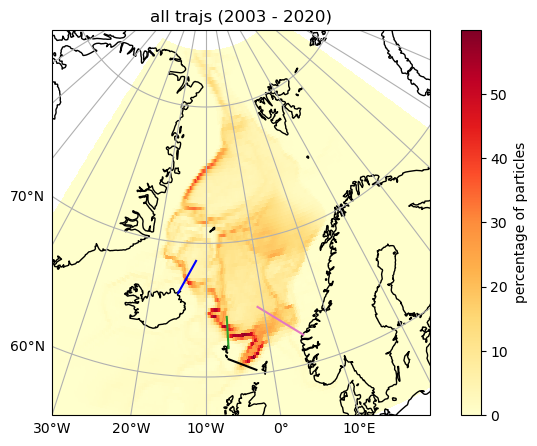

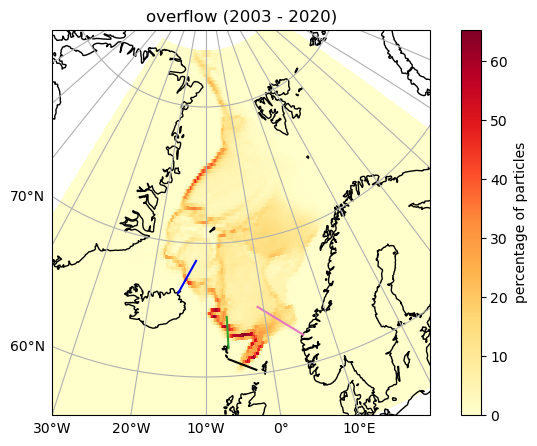

In [100]:
plot_particle_maps(heat_map_ds,'YlOrRd','percentage of particles','all trajs (2003 - 2020)') 

plot_particle_maps(heat_map_overflow,'YlOrRd','percentage of particles','overflow (2003 - 2020)') 


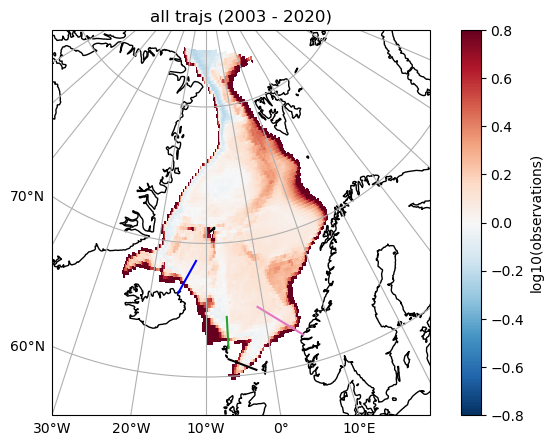

In [101]:
plot_particle_maps(np.log10(heat_map_ds)-np.log10(heat_map_overflow),'RdBu_r','log10(observations)','all trajs (2003 - 2020)',vmin=-.8,vmax=.8)


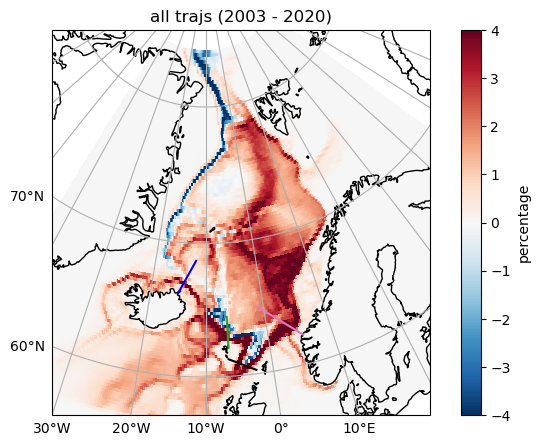

In [102]:
plot_particle_maps(heat_map_ds-heat_map_overflow,'RdBu_r','percentage','all trajs (2003 - 2020)',vmin=-4,vmax=4) 

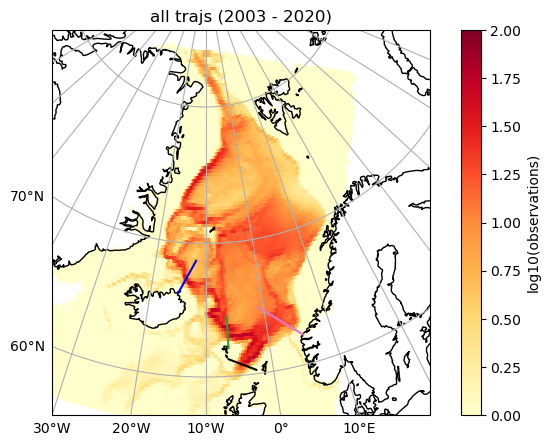

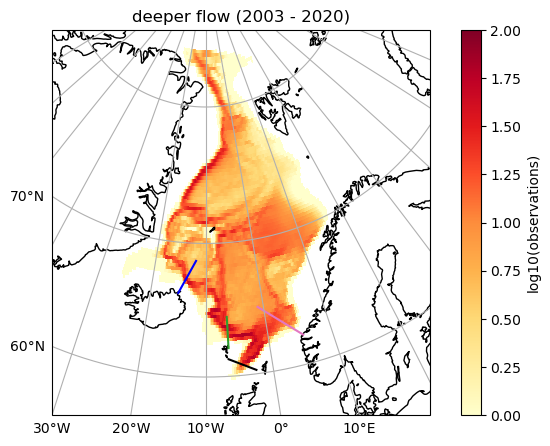

In [109]:
plot_particle_maps(np.log10(heat_map_ds),'YlOrRd','log10(observations)','all trajs (2003 - 2020)',vmin=0,vmax=2) 

plot_particle_maps(np.log10(heat_map_overflow),'YlOrRd','log10(observations)','deeper flow (2003 - 2020)',vmin=0,vmax=2) 


In [48]:
heat_map_ds_1999_2000 = compute_heat_maps(ds_1999_2000)['heat_map_probability']
heat_map_overflow_1999_2000 = compute_heat_maps(ds_overflow_1999_2000)['heat_map_probability']

In [49]:
heat_map_overflow_2010 = compute_heat_maps(ds_overflow_2010)['heat_map_probability']
heat_map_overflow_2012 = compute_heat_maps(ds_overflow_2012)['heat_map_probability']

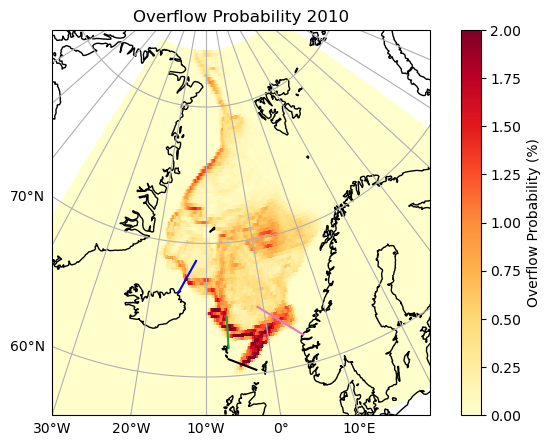

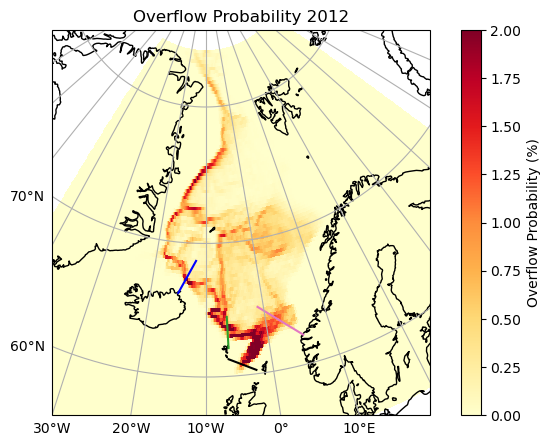

In [104]:
plot_particle_maps(heat_map_overflow_2010, 'YlOrRd', 'Overflow Probability (%)', 'Overflow Probability 2010',vmin=0,vmax=2)
plot_particle_maps(heat_map_overflow_2012, 'YlOrRd', 'Overflow Probability (%)', 'Overflow Probability 2012',vmin=0,vmax=2)

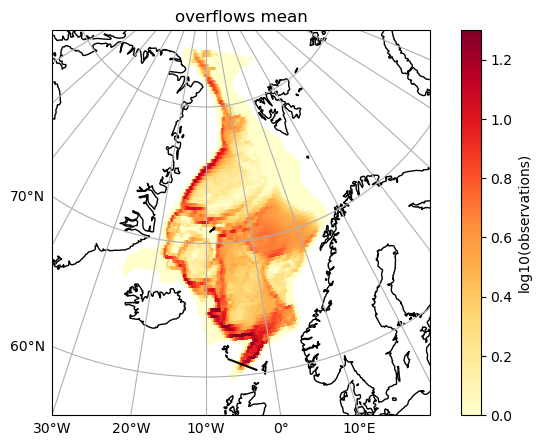

In [78]:
plot_particle_maps(np.log10(heat_map_overflow),'YlOrRd','log10(observations)','overflows mean', vmin=0,vmax=1.3) 

In [27]:
lon_rechunk, lat_rechunk = rechunk_lat_lon(ds_overflows)[0], rechunk_lat_lon(ds_overflows)[1]
def get_mean_maps(ds,lon_rechunk,lat_rechunk):
    weights = xr.ones_like(ds)
    weighted_sum = xhist(lon_rechunk, lat_rechunk, bins=[lon_bins, lat_bins], weights=ds, dim=["time", "trajectory"])
    counts = xhist(lon_rechunk, lat_rechunk, bins=[lon_bins, lat_bins], weights=weights, dim=["time", "trajectory"])
    mean_temp = weighted_sum / counts
    return mean_temp

In [94]:
mean_vvel_all = get_mean_maps(ds.vvel,rechunk_lat_lon(ds)[0], rechunk_lat_lon(ds)[1])
mean_vvel_all_cp = mean_vvel_all.compute()

2025-03-19 09:06:53,224 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x14e281186c90>>
Traceback (most recent call last):
  File "/gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebS

In [117]:
mean_depth_all = get_mean_maps(ds.z, rechunk_lat_lon(ds)[0], rechunk_lat_lon(ds)[1])
mean_depth_all_cp = mean_depth_all.compute()

In [69]:

mean_depth_overflows = get_mean_maps(ds_overflows.z,lon_rechunk,lat_rechunk)
mean_salt_overflows = get_mean_maps(ds_overflows.salt,lon_rechunk,lat_rechunk)
mean_age_overflows = get_mean_maps(ds_overflows.age,lon_rechunk,lat_rechunk)
mean_temp_overflows = get_mean_maps(ds_overflows.temp,lon_rechunk,lat_rechunk)

In [75]:
mean_vvel_overflows = get_mean_maps(ds_overflows.vvel,lon_rechunk,lat_rechunk)

In [28]:
# converting the age from nano seconds 

hours_to_days=0.0416667
hours_to_months=0.00136986
hours_to_years=0.000114155
time_conversion = hours_to_days
velocity_conversion = 1852 * 60 #multiply the value of the V field with 1852 * 60 (the number of meters in 1 degree of latitude)

In [71]:
%%time 

mean_age_overflows_cp = mean_age_overflows.compute()


CPU times: user 26.3 s, sys: 747 ms, total: 27 s
Wall time: 28.8 s


In [72]:
mean_depth_overflows_cp = mean_depth_overflows.compute()

In [73]:
mean_salt_overflows_cp = mean_salt_overflows.compute()
mean_temp_overflows_cp = mean_temp_overflows.compute()

In [78]:
mean_vvel_overflows_cp = mean_vvel_overflows.compute()

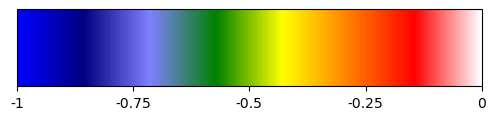

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the color gradient with a darker green
colors = [
    (0, 0, 1),      # Blue
    (0, 0, 0.5),    # Dark Blue
    (0.5, 0.5, 1),  # Light Blue
    (0, 0.5, 0),    # Darker Green (adjusted)
    (1, 1, 0),      # Yellow
    (1, 0.5, 0),    # Orange
    (1, 0, 0),      # Red
    (1, 1, 1)       # White
]

# Create a custom colormap
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1))

# Create a colorbar
norm = mcolors.Normalize(vmin=-1, vmax=0)
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal')

# Set ticks and labels for the range -1 to 0
cb.set_ticks(np.linspace(-1, 0, num=5))  # Adjust the number of ticks as needed
cb.set_ticklabels(['-1', '-0.75', '-0.5', '-0.25', '0'])  # Custom labels for the ticks

# Show the plot
plt.show()


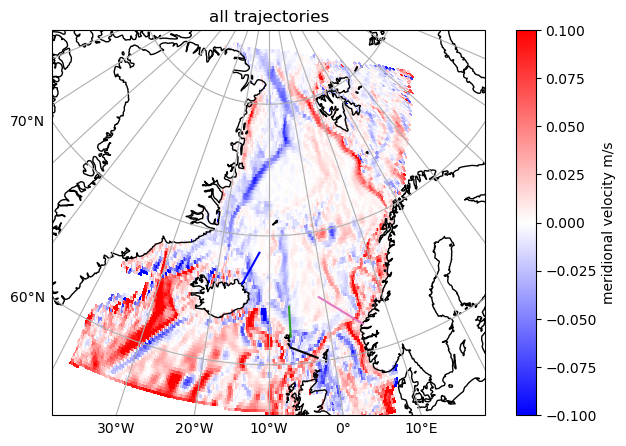

In [115]:
plot_particle_maps(mean_vvel_all_cp.T*velocity_conversion, 'bwr', 'meridional velocity m/s', 'all trajectories',vmin=-.1,vmax=.1)


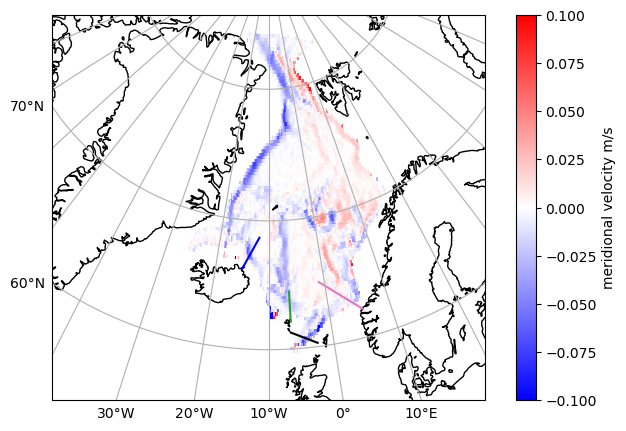

In [116]:
plot_particle_maps(mean_vvel_overflows_cp.T*velocity_conversion, 'bwr', 'meridional velocity m/s', '',vmin=-.1,vmax=.1)



In [123]:
#plot_particle_maps(mean_depth_all_cp.T, 'Blues_r', 'depth(m)', '', vmin=400,vmax=1000)


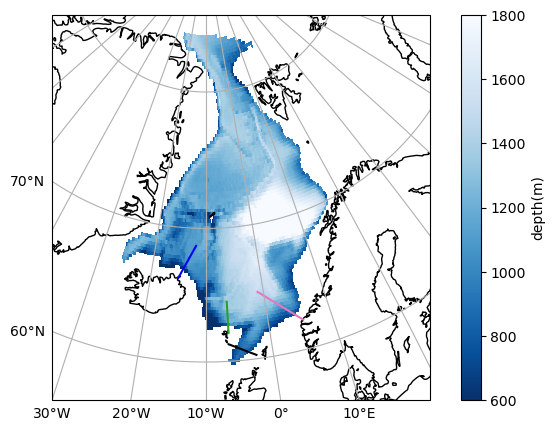

In [107]:
plot_particle_maps(mean_depth_overflows_cp.T, 'Blues_r', 'depth(m)', '', vmin=600,vmax=1800)


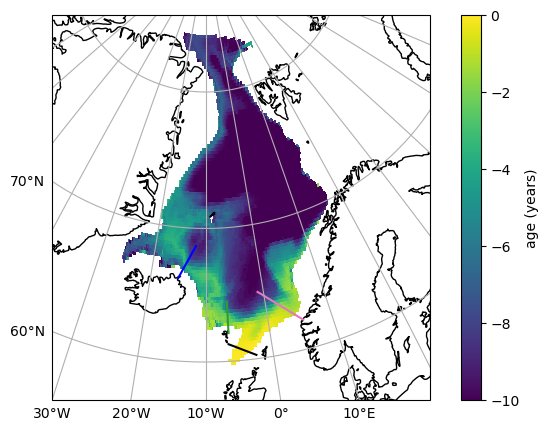

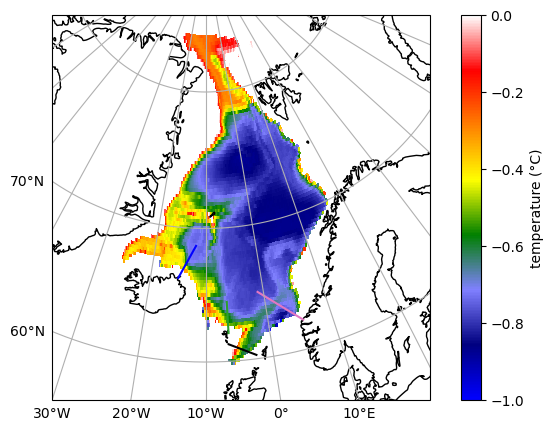

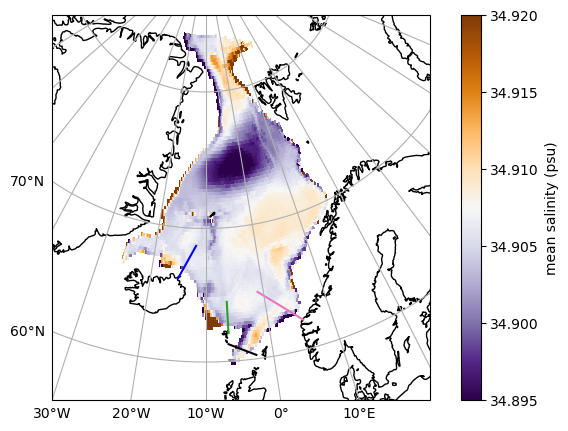

In [108]:
plot_particle_maps(mean_age_overflows_cp.T*hours_to_years, 'viridis', 'age (years)','',vmin=-10,vmax=0)

plot_particle_maps(mean_temp_overflows_cp.T, cmap, 'temperature (°C)', '', vmin=-1,vmax=0)

plot_particle_maps(mean_salt_overflows_cp.T, 'PuOr_r', 'mean salinity (psu)', '', vmin=34.895, vmax=34.92)


## get probability density maps from cross sections 

In [118]:
ds_orig = xr.open_dataset('data/level2/parcels_releases_seed-2345.zarr', engine='zarr', chunks='auto')
ds_orig = filter_beached_particles(ds_orig,'obs')

In [119]:
# Define the first section
EIC = (ds_orig.lon > -15) & (ds_orig.lat > 66.25) & (ds_orig.lon < -11.95) & (ds_orig.lat < 68.7)  #plot([-15, -11.95], [66.25, 68.7] plot([-15, -11.95], [66.25, 68.7] -- -16) & (ds_orig.lat > 66.25) & (ds_orig.lon < -10) & (ds_orig.lat < 69.16)

Svinoy = (ds_orig.lon < 5.5) & (ds_orig.lat > 62.24) & (ds_orig.lon > -1) & (ds_orig.lat < 65) 

N_section = (ds_orig.lon > -6.0833-5) & (ds_orig.lat > 62.3333) & (ds_orig.lon < -6.0833+5) & (ds_orig.lat < 64.5)

Svinoy_box = ds_orig.where(Svinoy, drop=False)
EIC_box = ds_orig.where(EIC, drop=False)
N_box = ds_orig.where(N_section, drop=False)
total_domain_box = ds_orig.where((ds_orig.lon > -42) & (ds_orig.lat > 53) & (ds_orig.lon < 47) & (ds_orig.lat < 85), drop=False)


In [120]:
def calculate_slope_intercept(x1, y1, x2, y2):
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    return m, b


# Calculate slope and intercept
dist = .4
m_Svinoy, b_Svinoy = calculate_slope_intercept(5.5, 62.24 - dist, -1, 65 - dist)
m_Svinoy2, b_Svinoy2 = calculate_slope_intercept(5.5, 62.24 + dist, -1, 65 + dist)  # .8 comes from max 2m/s velocity*12h = 86km convert km to degree = ~.77 degree
# but use area with cross section line as midpoint 
# Print the results
print("slope (m) is:", m_Svinoy)
print("y-intercept (b) is:", b_Svinoy)

m_EIC, b_EIC = calculate_slope_intercept(-15, 66.25 - dist, -11.95, 68.7 - dist)  # (-15, 66.25-dist, -11.95, 68.7-dist) # extended - -16, 66.25-dist, -10, 69.16-dist)
m_EIC2, b_EIC2 = calculate_slope_intercept(-15, 66.25 + dist, -11.95, 68.7 + dist)
print("slope (m) is:", m_EIC, m_EIC2)
print("y-intercept (b) is:", b_EIC, b_EIC2)

# Svinoy section

ds_Svinoy_window = Svinoy_box.lat >= Svinoy_box.lon * m_Svinoy + b_Svinoy  # if latitude above that line, set to True
ds_Svinoy_window2 = Svinoy_box.lat <= Svinoy_box.lon * m_Svinoy2 + b_Svinoy2  # if latitude BELOW that line, set to True
ds_Svinoy_line_cross = (Svinoy_box.lat >= Svinoy_box.lon * m_Svinoy + b_Svinoy) & (Svinoy_box.lat <= Svinoy_box.lon * m_Svinoy2 + b_Svinoy2)

ds_Svinoy_window = ds_Svinoy_window.astype(int)
ds_Svinoy_window2 = ds_Svinoy_window2.astype(int)
ds_Svinoy_line_cross = ds_Svinoy_line_cross.astype(int)

# ds_Svinoy_window
ds_Svinoy = ds_orig.where(ds_Svinoy_window, drop=False)
ds_Svinoy2 = ds_orig.where(ds_Svinoy_window2, drop=False)

ds_Svinoy_line = ds_orig.where(ds_Svinoy_window & ds_Svinoy_window2, drop=False)

# EIC section

ds_EIC_window = EIC_box.lat >= EIC_box.lon * m_EIC + b_EIC  # if latitude above that line, set to True
ds_EIC_window2 = EIC_box.lat <= EIC_box.lon * m_EIC2 + b_EIC2  # if latitude BELOW that line, set to True
ds_EIC_line_cross = (EIC_box.lat >= EIC_box.lon * m_EIC + b_EIC) & (EIC_box.lat <= EIC_box.lon * m_EIC2 + b_EIC2)

ds_EIC_window = ds_EIC_window.astype(int)
ds_EIC_window2 = ds_EIC_window2.astype(int)
ds_EIC_line_cross = ds_EIC_line_cross.astype(int)

# ds_EIC_window
ds_EIC = ds_orig.where(ds_EIC_window, drop=False)
ds_EIC2 = ds_orig.where(ds_EIC_window2, drop=False)

ds_EIC_line = ds_orig.where(ds_EIC_window & ds_EIC_window2, drop=False)

# N section

ds_N_window = (N_box.lon <= -6.0833 + .1).astype(int)
ds_N_window2 = (N_box.lon >= -6.0833 - .1).astype(int)
ds_N_line_cross = (N_box.lon <= -6.0833 + .1) & (N_box.lon >= -6.0833 - .1).astype(int)

ds_N = ds_orig.where(ds_N_window, drop=False)
ds_N2 = ds_orig.where(ds_N_window2, drop=False)

ds_N_line = ds_orig.where(ds_N_window & ds_N_window2, drop=False)


slope (m) is: -0.42461538461538323
y-intercept (b) is: 64.17538461538462
slope (m) is: 0.803278688524591 0.803278688524591
y-intercept (b) is: 77.89918032786886 78.69918032786887


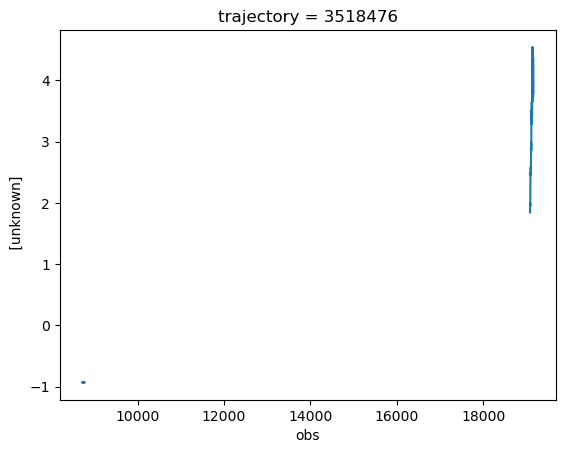

In [108]:
ds_Svinoy_line.isel(trajectory=-100).temp.plot()

In [121]:
def compute_heat_map(ds): #.nbytes/1e9
    heat_map_obs = xhist(ds.lat, ds.lon, bins=[lat_bins, lon_bins], dim=['obs'], bin_dim_suffix="")
    heat_map_obs_unique = (heat_map_obs > 0).sum(dim='trajectory')
    heat_map_probability_cp = heat_map_obs_unique.compute()
    return heat_map_normalized_cp

In [35]:
# heat_map_obs = xhist(ds_orig.lat, ds_orig.lon, bins=[lat_bins, lon_bins], dim=['obs'], bin_dim_suffix="")

# heat_map_obs_unique = (heat_map_obs > 0).sum(dim='trajectory')

# #total_particles = ds_orig.trajectory.size

# #heat_map_probability = (heat_map_obs_unique / total_particles) * 100

# heat_map_probability_cp = heat_map_obs_unique.compute()


In [ ]:
# nans = ds_N_line['temp'].isnull().sum(dim='obs').compute()
# traj_not_svinoy = ds_orig.sel(trajectory=(nans == ds.obs.size))
# traj_svinoy = ds_orig.sel(trajectory=(nans != ds.obs.size))
# traj_all = ds_orig

In [122]:
def filter_trajectories(ds_line):
    """
    Filters trajectories based on whether they cross the line.

    Parameters:
    ds_orig (xarray.Dataset): The original dataset containing trajectory data.
    ds_line (xarray.Dataset): The dataset containing the line information.

    Returns:
    traj_not_line (xarray.Dataset): Trajectories that do not cross the line.
    traj_line (xarray.Dataset): Trajectories that cross the line.
    traj_all (xarray.Dataset): All trajectories from the original dataset.
    """
    # Count the number of NaN values in the 'temp' variable across the 'obs' dimension
    nans = ds_line['temp'].isnull().sum(dim='obs').compute()
    
    # Select trajectories based on the NaN count
    traj_not_line = ds_line.sel(trajectory=(nans == ds_line.obs.size))
    traj_line = ds_line.sel(trajectory=(nans != ds_line.obs.size))
    
    # Return all trajectories
    traj_all = ds_line

    return {
        'traj_line': traj_line,
        'traj_not_line': traj_not_line,
        'traj_all': traj_all
    }


def compute_probability(traj_line_not_all):
    heat_map_obs_non = xhist(traj_line_not_all.lat, traj_line_not_all.lon, bins=[lat_bins, lon_bins], dim=['obs'], bin_dim_suffix="")
    heat_map_obs_unique_non = (heat_map_obs_non > 0).sum(dim='trajectory')
    heat_map_probability_non_cp = heat_map_obs_unique_non.compute()
    return heat_map_probability_non_cp

In [148]:
ds_line = ds_EIC_line

nans = ds_line['temp'].isnull().sum(dim='obs').compute()

# Select trajectories based on the NaN count
traj_not_line = ds_line.sel(trajectory=(nans == ds_line.obs.size))
traj_line = ds_line.sel(trajectory=(nans != ds_line.obs.size))

# Return all trajectories
traj_all = ds_line

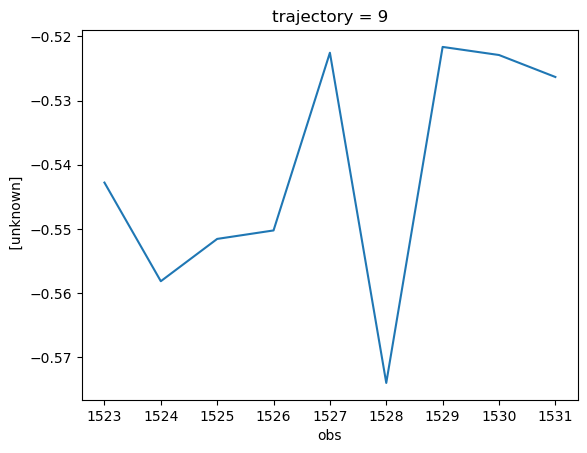

In [114]:
traj_line.isel(trajectory=0).temp.plot()    

In [146]:
# Ensure that the entire area is being considered
heat_map_obs_non = xhist(traj_all.lat, traj_all.lon, bins=[lat_bins, lon_bins], dim=['obs'], bin_dim_suffix="")

heat_map_obs_unique_non = (heat_map_obs_non > 0).sum(dim='trajectory')

heat_map_probability_non_cp = heat_map_obs_unique_non.compute()


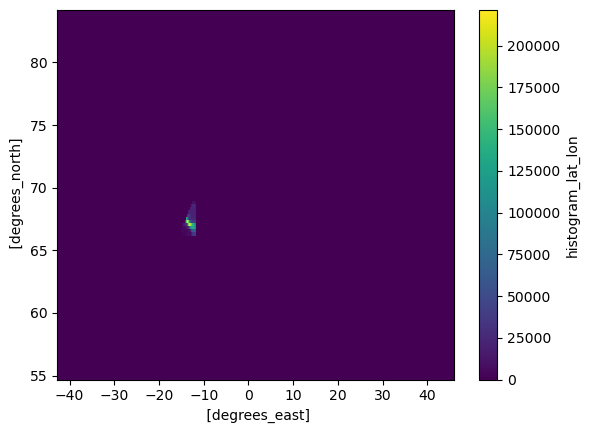

In [147]:
heat_map_probability_non_cp.plot();

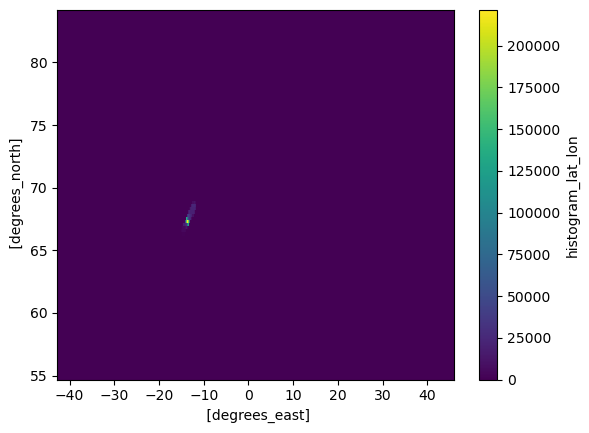

In [132]:
heat_map_probability_non_cp.plot();

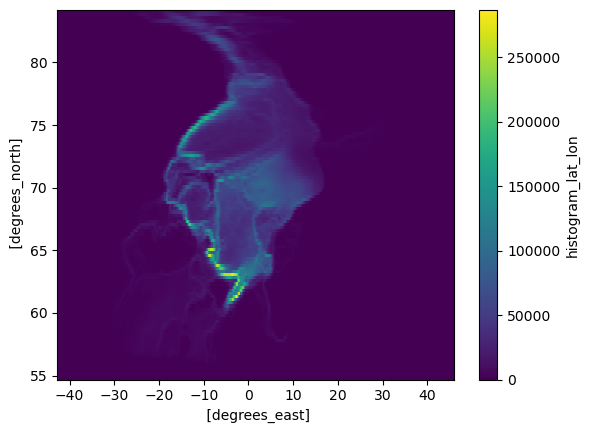

In [97]:
heat_map_probability_all_trajs_cp.plot()

In [85]:
on_Svinoy = filter_trajectories(ds_Svinoy_line)
heat_map_probability_Svinoy_cp = compute_probability(on_Svinoy['traj_line'])

In [124]:
heat_map_all_trajs = filter_trajectories(ds_orig)

In [125]:
heat_map_probability_all_trajs_cp = compute_probability(heat_map_all_trajs['traj_all'])

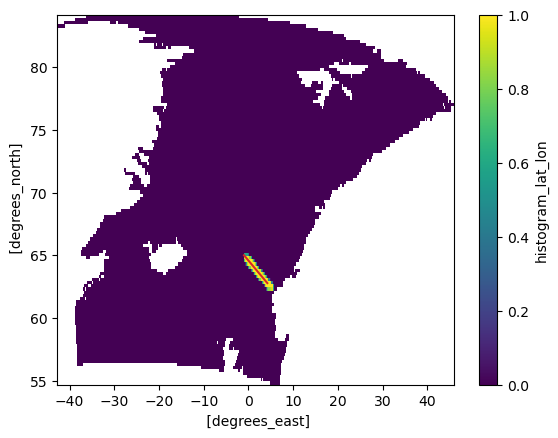

In [129]:
(heat_map_probability_Svinoy_cp/heat_map_probability_all_trajs_cp).plot()
plt.plot([4.21, -1], [62.78, 65.], color='tab:red', label='Svinoy section')
plt.show()


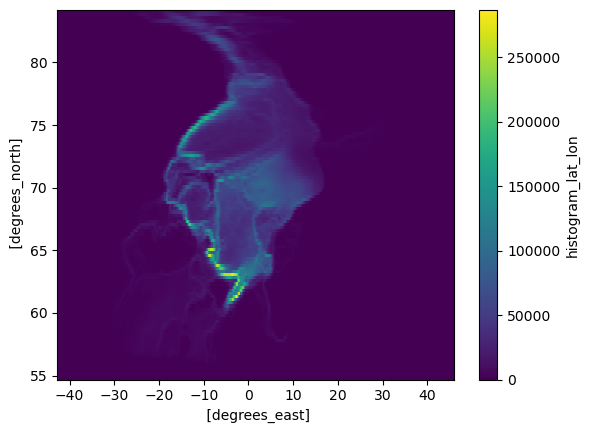

In [130]:
heat_map_probability_all_trajs_cp.plot()

In [ ]:
heatmap_Svinoy = compute_probability(on_Svinoy['traj_line'])



In [99]:
nans = ds_N_line['temp'].isnull().sum(dim='obs').compute()

In [100]:
traj_off_line = ds_N_line.sel(trajectory=(nans == 20075))
traj_on_line = ds_N_line.sel(trajectory=(nans != 20075))
traj_all = ds_N_line

In [101]:
binning = xhist(traj_on_line.lat, traj_on_line.lon, bins=[lat_bins, lon_bins], dim=['obs'], bin_dim_suffix="")

hmap_unique = (heat_map_obs_non > 0).sum(dim='trajectory')

hmap_unique_cp = hmap_unique.compute()


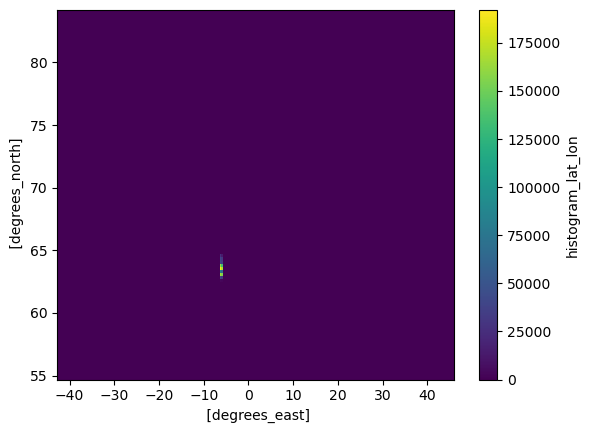

In [102]:
hmap_unique_cp.plot();

In [153]:
nans_none = (ds_N_line['temp'].isnull() & ds_Svinoy_line['temp'].isnull()).sum(dim='obs')

In [154]:
traj_not = ds_orig.sel(trajectory=(nans_none == 20075))

In [155]:
heat_map_obs_non = xhist(traj_not.lat, traj_not.lon, bins=[lat_bins, lon_bins], dim=['obs'], bin_dim_suffix="")

heat_map_obs_unique_non = (heat_map_obs_non > 0).sum(dim='trajectory')

heat_map_probability_non_cp = heat_map_obs_unique_non.compute()


In [56]:
(heat_map_probability_non_cp/heat_map_probability_cp).plot()
plt.plot([-6.43, -6.43], [62.15, 64.5], color='tab:green', label='N section')
plt.show()


NameError: name 'heat_map_probability_non_cp' is not defined

In [139]:
traj_not_svinoy = ds_Svinoy_line.sel(trajectory=(nans == 20075))
traj_svinoy = ds_Svinoy_line.sel(trajectory=(nans != 20075))
traj_all = ds_Svinoy_line

In [140]:
heat_map_obs_Svinoy = xhist(traj_svinoy.lat, traj_svinoy.lon, bins=[lat_bins, lon_bins], dim=['obs'], bin_dim_suffix="")

heat_map_obs_unique_Svinoy = (heat_map_obs_Svinoy > 0).sum(dim='trajectory')


heat_map_probability_Svinoy_cp = heat_map_obs_unique_Svinoy.compute()

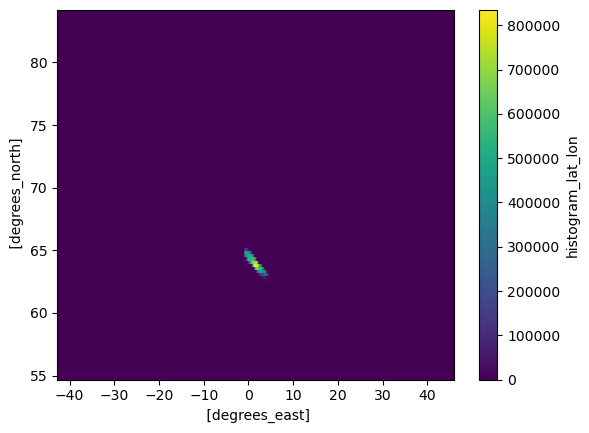

In [144]:
heat_map_obs_Svinoy.sum(dim='trajectory').plot();

In [149]:
traj_not_svinoy = ds_orig.sel(trajectory=(nans == 20075))
traj_svinoy = ds_orig.sel(trajectory=(nans != 20075))
traj_all = ds_orig

In [151]:
heat_map_obs_Svinoy = xhist(traj_svinoy.lat, traj_svinoy.lon, bins=[lat_bins, lon_bins], dim=['obs'], bin_dim_suffix="")

heat_map_obs_unique_Svinoy = (heat_map_obs_Svinoy > 0).sum(dim='trajectory')

# total_particles = ds_orig.trajectory.size

# heat_map_probability_Svinoy = (heat_map_obs_unique_Svinoy / total_particles) * 100

heat_map_probability_Svinoy_cp = heat_map_obs_unique_Svinoy.compute()

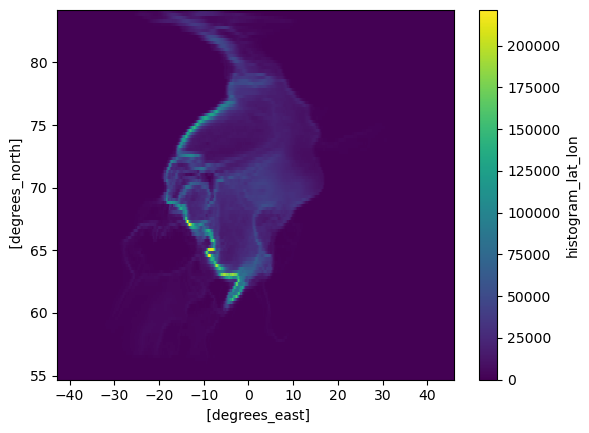

In [152]:
heat_map_probability_Svinoy_cp.plot();

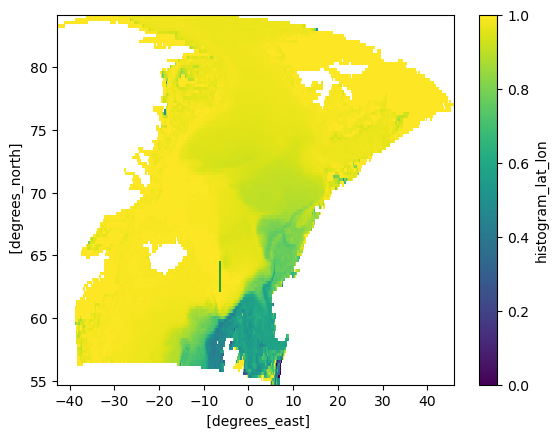

In [152]:
(heat_map_probability_Svinoy_cp/heat_map_probability_cp).plot()
plt.plot([-6.43, -6.43], [62.15, 64.5], color='tab:green', label='N section')
plt.show()


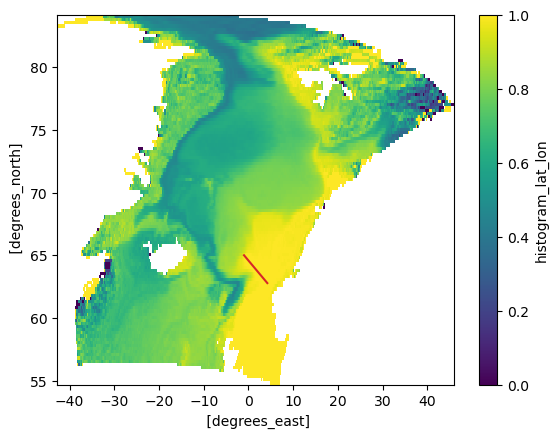

In [141]:
(heat_map_probability_Svinoy_cp/heat_map_probability_cp).plot()
plt.plot([4.21, -1], [62.78, 65.], color='tab:red', label='Svinoy section')
plt.show()


In [103]:
heat_map_probability_cp.plot();

NameError: name 'heat_map_probability_cp' is not defined

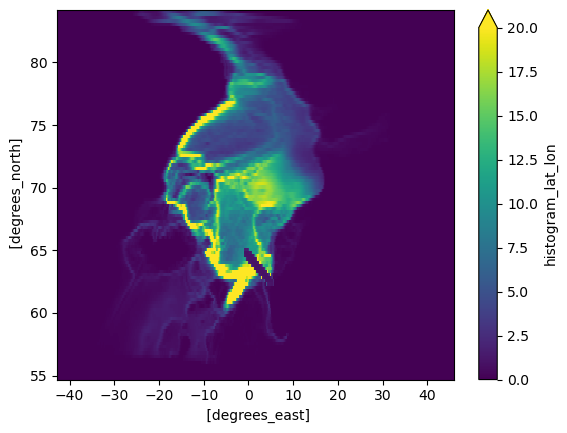

In [84]:
(heat_map_probability_cp/test).plot(vmin=0,vmax=20)

In [79]:
test = xr.where(heat_map_probability_Svinoy_cp == 0, 1, heat_map_probability_Svinoy_cp)

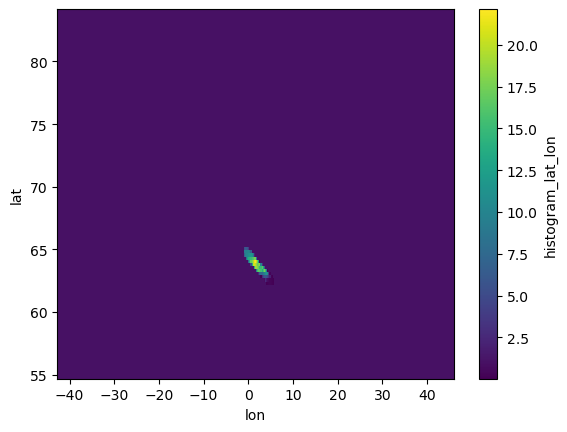

In [81]:
test.plot()

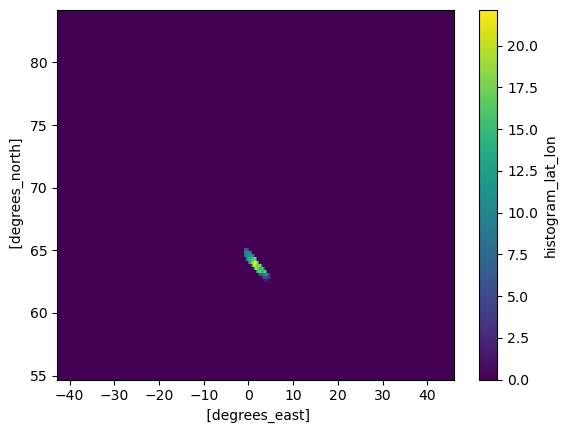

In [78]:
heat_map_probability_Svinoy_cp.plot()

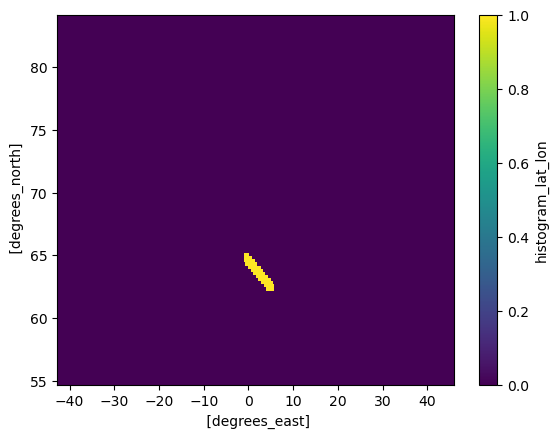

In [74]:
xr.where(heat_map_probability_Svinoy_cp> 0, 1,0).plot()

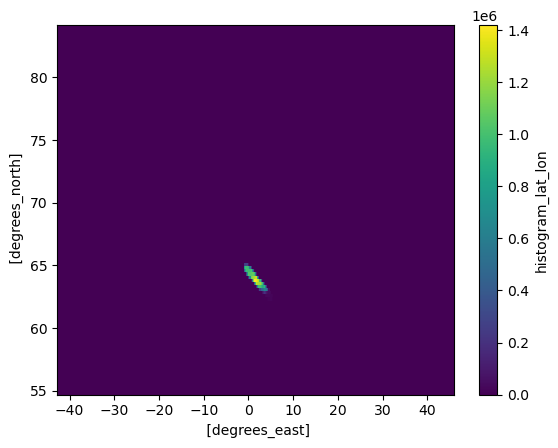

In [69]:
test.plot();

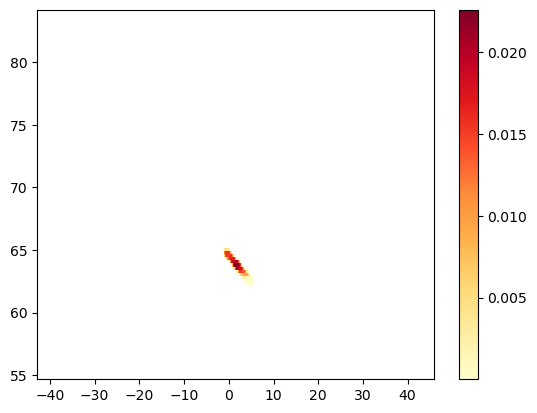

In [51]:
plt.pcolormesh(ds_Svinoy_line_map.lon,ds_Svinoy_line_map.lat,ds_Svinoy_line_map.where(ds_Svinoy_line_map>0),cmap='YlOrRd')
plt.colorbar()
plt.show()

In [59]:
mask = ds_Svinoy_line.notnull().any(dim='obs')  # This will create a boolean mask where data is present


In [65]:
mask.isel(trajectory=100).salt.plot();

TypeError: No numeric data to plot.

In [60]:
test = xhist(mask.lat, mask.lon, bins=[lat_bins, lon_bins], bin_dim_suffix="") 

<xarray.DataArray 'histogram_lat_lon' (lat: 118, lon: 355)>
dask.array<sum-aggregate, shape=(118, 355), dtype=int64, chunksize=(118, 355), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.8 55.05 55.3 55.55 55.8 ... 83.3 83.55 83.8 84.05
  * lon      (lon) float64 -42.67 -42.42 -42.17 -41.92 ... 45.33 45.58 45.83